In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import shannon

# import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /home/lane/.config/matplotlib/stylelib/deepretina2.mplstyle: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(message)
/home/lane/.local/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /home/lane/.config/matplotlib/stylelib/deepretina2.mplstyle: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(message)


In [2]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [3]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

# Information analysis  
  
  Still some aspects of this analysis are counter-intuitive. For instance, the horizontal weight should presumably be much lower for such a high SNR. And why don't we see diverse horizontal weights? Let's move to an analysis where we specifically compute the mutual information.

In [4]:
def rf_model(horz_weight, center_weight):
    return center_weight*constants['center'] + (1-center_weight)*(
        horz_weight*constants['horz_pf'] + (1-horz_weight)*constants['ama_pf'])

In [5]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [6]:
blah = generate_spatial_signals(10000)

In [7]:
blah.shape

(10000, 398)

In [8]:
sigma_x = np.cov(blah.T, ddof=1)

In [9]:
sigma_x.shape

(398, 398)

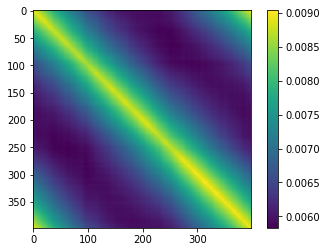

In [10]:
plt.imshow(sigma_x)
plt.colorbar()

In [11]:
sigma_x.mean()

0.0069141523252564292

In [12]:
sigma_x.var()

7.8101179130340023e-07

In [13]:
blah.shape

(10000, 398)

In [14]:
blah.T.shape

(398, 10000)

In [15]:
tmp1 = np.zeros((398, 1000))
tmp2 = np.zeros((50, 1000))

In [16]:
np.vstack([tmp1, tmp2]).shape

(448, 1000)

In [17]:
def mutual_information(x, y):
    '''Mutual information between two multivariate Gaussians.
    
    Args:
        x: 2d array with each row representing a variable, and each
            column a single observation of all those variables.
        y: 2d array with each row representing a variable, and each
            column a single oberservation of all those variables.
    Returns:
        info: Mutual information between x and y in nats.
    '''
    x_vars = x.shape[0]
    y_vars = y.shape[0]
    x_obs = x.shape[1]
    y_obs = y.shape[1]
    assert x_obs == y_obs, 'X and Y must have the same number of observations.'
    
    cov_x = np.cov(x, ddof=1)
    cov_y = np.cov(y, ddof=1)
    cov_xy = np.cov(np.vstack([x, y]), ddof=1)
    
    # entropy_x = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_x))
    # entropy_y = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_y))
    # entropy_xy = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_xy))
    inside_x = np.linalg.det(2 * np.pi * np.e * cov_x)
    inside_y = np.linalg.det(2 * np.pi * np.e * cov_y)
    inside_xy = np.linalg.det(2 * np.pi * np.e * cov_xy)
    
    return 0.5 * np.log(inside_x * inside_y / inside_xy)

In [18]:
np.logspace(3, 5, 10).astype('int')

array([  1000,   1668,   2782,   4641,   7742,  12915,  21544,  35938,
        59948, 100000])

In [19]:
asymptotic_entropy = []
datapoints = np.logspace(1, 4, 10).astype('int')
for n in tqdm(datapoints):
    x = np.random.randn(50, n)
    y = np.random.randn(21, n)
    mi = mutual_information(x, y)
    asymptotic_entropy.append(mi)

  0%|          | 0/10 [00:00<?, ?it/s]/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 97.52it/s]


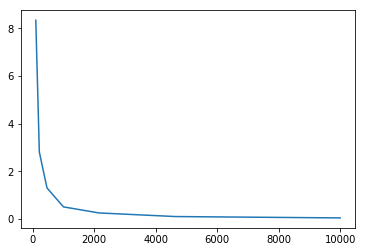

In [20]:
plt.plot(datapoints, asymptotic_entropy)

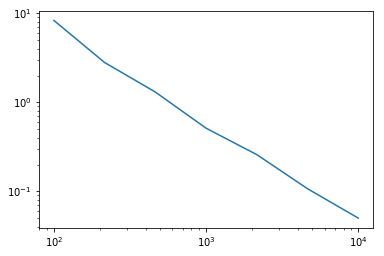

In [21]:
plt.plot(datapoints, asymptotic_entropy)
plt.yscale('log')
plt.xscale('log')

In [22]:
cov_x = np.cov(x, ddof=1)
cov_y = np.cov(y, ddof=1)
cov_xy = np.cov(np.vstack([x, y]), ddof=1)

entropy_x = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_x))
entropy_y = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_y))
entropy_xy = 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * cov_xy))


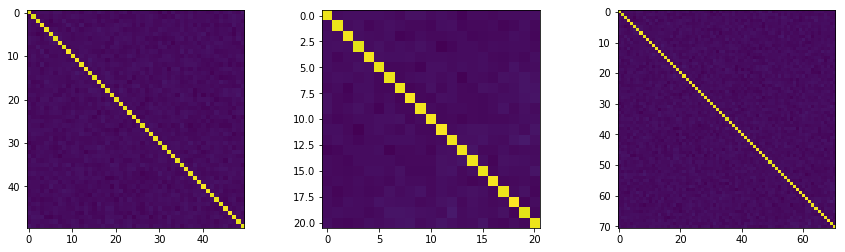

In [23]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.imshow(cov_x)
plt.subplot(1, 3, 2)
plt.imshow(cov_y)
plt.subplot(1, 3, 3)
plt.imshow(cov_xy)

In [24]:
entropy_x

70.868209273564801

In [25]:
entropy_y

29.815782747477243

In [26]:
entropy_xy

100.63396438696111

In [27]:
entropy_x + entropy_y - entropy_xy

0.050027634080933581

## Good reminder that we need lots of data to avoid overestimating MI!

In [28]:
N = 1000
hw = 0.5
cw = 0.5
spatial_signals = generate_spatial_signals(N)
out = []
for s in spatial_signals:
    out.append(np.convolve(s, rf_model(hw, cw), mode='same'))
output = np.stack(out)

In [29]:
xy = np.vstack([spatial_signals.T, output.T])

In [30]:
cov_s = np.cov(spatial_signals.T, ddof=1)
cov_o = np.cov(output.T, ddof=1)
cov_so = np.cov(xy, ddof=1)

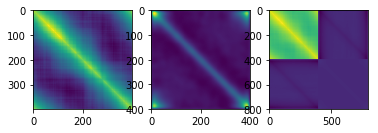

In [31]:
plt.subplot(1, 3, 1)
plt.imshow(cov_s)
plt.subplot(1, 3, 2)
plt.imshow(cov_o)
plt.subplot(1, 3, 3)
plt.imshow(cov_so)

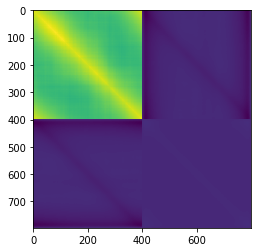

In [32]:
plt.imshow(cov_so)

In [33]:
mi = mutual_information(spatial_signals.T, output.T)

/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [34]:
mi

nan

In [35]:
N = 100000
hw = 0.5
cw = 0.5
spatial_signals = generate_spatial_signals(N)
out = []
for s in spatial_signals:
    out.append(np.convolve(s, rf_model(hw, cw), mode='same'))
output = np.stack(out)
mi = mutual_information(spatial_signals.T, output.T)

/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
mi

nan

In [37]:
np.linalg.det(cov_o)

-0.0

In [38]:
np.linalg.det(cov_s)

0.0

In [39]:
np.linalg.det(cov_so)

0.0

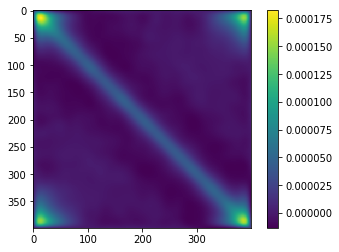

In [40]:
plt.imshow(cov_o)
plt.colorbar()

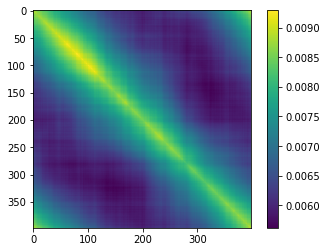

In [41]:
plt.imshow(cov_s)
plt.colorbar()

In [42]:
N = 10000
hw = 0.5
cw = 0.5
spatial_signals = generate_spatial_signals(N)
out = []
for s in tqdm(spatial_signals):
    input_noise = np.random.randn(*s.shape)
    conv_out = np.convolve(s + input_noise, rf_model(hw, cw), mode='same')
    output_noise = np.random.randn(*conv_out.shape)
    out.append(conv_out + output_noise)
output = np.stack(out)
mi = mutual_information(spatial_signals.T, output.T)

cov_s = np.cov(spatial_signals.T, ddof=1)
cov_o = np.cov(output.T, ddof=1)
cov_so = np.cov(xy, ddof=1)

100%|██████████| 10000/10000 [00:00<00:00, 11209.12it/s]
/home/lane/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


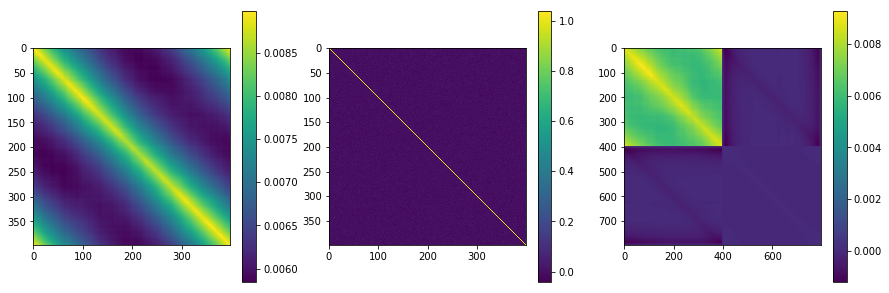

In [43]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cov_s)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(cov_o)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(cov_so)
plt.colorbar()

In [44]:
x = spatial_signals.T
y = output.T

In [45]:
x -= np.expand_dims(np.mean(x, axis=1), axis=1)
y -= np.expand_dims(np.mean(y, axis=1), axis=1)

In [46]:
np.linalg.det(cov_s)

0.0

In [47]:
np.linalg.det(cov_o)

0.0018144350168265684

In [48]:
np.linalg.det(cov_so)

0.0

In [49]:
cov_s.shape

(398, 398)

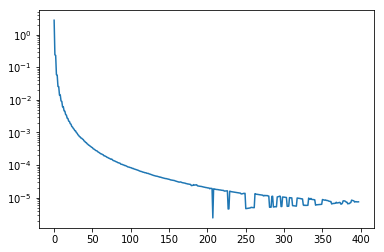

In [50]:
plt.plot(np.linalg.eigvals(cov_s))
plt.yscale('log')

In [51]:
eigs = np.linalg.eigvals(2 * np.pi * np.e * cov_s)
eigs.min()

4.0995965088864452e-05

In [52]:
np.log(eigs.min())

-10.102036908569511

In [53]:
log_eigs = [np.log(e) for e in eigs]

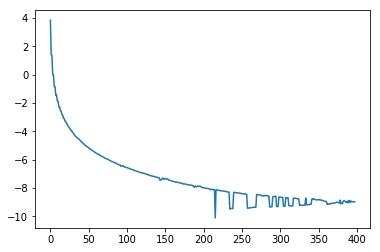

In [54]:
plt.plot(log_eigs)

In [55]:
0.5 * np.sum(log_eigs)

-1462.860203834427

In [56]:
constants.keys()

dict_keys(['microns_per_degree', 'pixelsToDeg', 'photoreceptor_width', 'retina_width', 'frequency_spacing', 'highest_frequency', 'receptive_fields', 'N', 'freqs', 'space', 'spacing', 'contrast', 'center_widths', 'surround_widths', 'center_strengths', 'surround_strengths', 'fit_failures', 'median_center_widths', 'horz_pf', 'ama_pf', 'target_power', 'resolution', 'info_maps', 'failures', 'detailed_failures', 'celltype', 'center', 'input_noise', 'output_noise', 'target_snr'])

In [57]:
constants['photoreceptor_width']

0.2

In [58]:
constants['frequency_spacing']

0.0125

In [59]:
constants['freqs']

array([ 0.        ,  0.01256281,  0.02512563,  0.03768844,  0.05025126,
        0.06281407,  0.07537688,  0.0879397 ,  0.10050251,  0.11306533,
        0.12562814,  0.13819095,  0.15075377,  0.16331658,  0.1758794 ,
        0.18844221,  0.20100503,  0.21356784,  0.22613065,  0.23869347,
        0.25125628,  0.2638191 ,  0.27638191,  0.28894472,  0.30150754,
        0.31407035,  0.32663317,  0.33919598,  0.35175879,  0.36432161,
        0.37688442,  0.38944724,  0.40201005,  0.41457286,  0.42713568,
        0.43969849,  0.45226131,  0.46482412,  0.47738693,  0.48994975,
        0.50251256,  0.51507538,  0.52763819,  0.54020101,  0.55276382,
        0.56532663,  0.57788945,  0.59045226,  0.60301508,  0.61557789,
        0.6281407 ,  0.64070352,  0.65326633,  0.66582915,  0.67839196,
        0.69095477,  0.70351759,  0.7160804 ,  0.72864322,  0.74120603,
        0.75376884,  0.76633166,  0.77889447,  0.79145729,  0.8040201 ,
        0.81658291,  0.82914573,  0.84170854,  0.85427136,  0.86

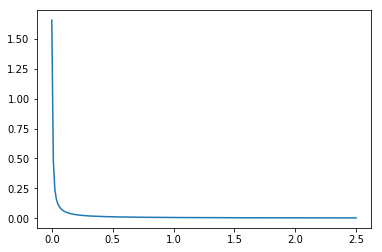

In [60]:
plt.plot(constants['freqs'], signal)

In [61]:
0.5 * np.sum(log_eigs[:4])

3.3175473284168326

In [62]:
eigs_s = abs(np.linalg.eigvals(2 * np.pi * np.e * cov_s))
eigs_o = abs(np.linalg.eigvals(2 * np.pi * np.e * cov_o))
eigs_so = abs(np.linalg.eigvals(2 * np.pi * np.e * cov_so))

log_eigs_s = [np.log(e) for e in eigs_s]
log_eigs_o = [np.log(e) for e in eigs_o]
log_eigs_so = [np.log(e) for e in eigs_so]

In [63]:
np.sum(log_eigs_s)

-2925.720407668854

In [64]:
log_eigs_s[:4]

[3.8505244692014893,
 1.4046457500399989,
 1.3757367597971928,
 0.0041876777949833143]

In [65]:
np.sum(log_eigs_o)

1126.0009683521093

In [66]:
np.sum(log_eigs_so[:3])

6.6014165288835382

In [67]:
np.sum(log_eigs_so)

-19432.483283038244

In [68]:
np.sum(log_eigs_s[:4]) + np.sum(log_eigs_o) - np.sum(log_eigs_so)

20565.119346047188

# Try other method of MI estimation

In [69]:
from shannon import discrete
from shannon import continuous

In [70]:
discrete.entropy

<function shannon.discrete.entropy>

In [71]:
x.shape

(398, 10000)

In [72]:
y.shape

(399, 10000)

In [73]:
continuous.entropy(x.T)

/home/lane/ssd/code/shannon/shannon/continuous.py:80: RuntimeWarning: divide by zero encountered in log2
  return k*np.mean(np.log2(rho)) + np.log2(num_samples*Ak/k) + np.log2(np.exp(1))*np.euler_gamma


-inf

In [74]:
continuous.entropy(y.T)

/home/lane/ssd/code/shannon/shannon/continuous.py:80: RuntimeWarning: divide by zero encountered in log2
  return k*np.mean(np.log2(rho)) + np.log2(num_samples*Ak/k) + np.log2(np.exp(1))*np.euler_gamma


-inf

In [76]:
x.T.shape

(10000, 398)

In [78]:
continuous.entropy(x.T, method='bin', bins=[10] * x.T.shape[1])

ValueError: sequence too large; cannot be greater than 32

In [79]:
H, edges = np.histogramdd(x.T)

ValueError: sequence too large; cannot be greater than 32

In [104]:
x.T.shape

(10000, 398)

In [106]:
x.T[:2, ::100].shape

(2, 4)

In [107]:
H, edges = np.histogramdd(x.T[:, ::100], normed=True)

In [109]:
H.min()

0.0

In [110]:
H.max()

888.29590807491763

In [111]:
np.sum(H)

32657.937796871978

In [112]:
continuous.entropy(prob=H/np.sum(H), method='bin')

/home/lane/ssd/code/shannon/shannon/continuous.py:116: RuntimeWarning: divide by zero encountered in log2
  logProb = np.log2(prob)


7.805219168472201

In [113]:
Hy, edges_y = np.histogramdd(y.T[:, ::100], normed=True)

In [114]:
Hy /= np.sum(Hy)

In [115]:
Hy.shape

(10, 10, 10, 10)

In [116]:
continuous.entropy(prob=Hy, method='bin')

/home/lane/ssd/code/shannon/shannon/continuous.py:116: RuntimeWarning: divide by zero encountered in log2
  logProb = np.log2(prob)


9.819717984738283

In [118]:
xyT = np.hstack([x.T[:, ::100], y.T[:, ::100]])

In [119]:
Hxy, edges_xy = np.histogramdd(xyT, normed=True)

In [120]:
Hxy /= np.sum(Hxy)

In [121]:
Hxy.shape

(10, 10, 10, 10, 10, 10, 10, 10)

In [122]:
continuous.entropy(prob=Hxy, method='bin')

/home/lane/ssd/code/shannon/shannon/continuous.py:116: RuntimeWarning: divide by zero encountered in log2
  logProb = np.log2(prob)


13.17065246674143

In [123]:
Hx = H/np.sum(H)

In [124]:
continuous.entropy(prob=Hx, method='bin') + continuous.entropy(prob=Hy, method='bin') - continuous.entropy(prob=Hxy, method='bin')

/home/lane/ssd/code/shannon/shannon/continuous.py:116: RuntimeWarning: divide by zero encountered in log2
  logProb = np.log2(prob)


4.454284686469052

In [139]:
blah = np.cov(x[::100], y[::100])

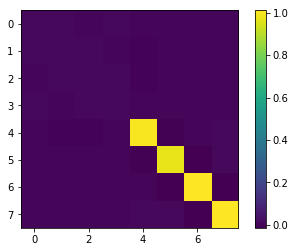

In [141]:
plt.imshow(blah)
plt.colorbar()

In [142]:
bloop = np.cov(x[::100])

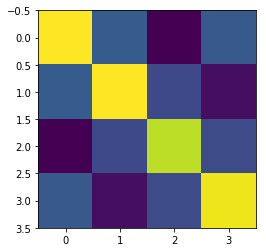

In [143]:
plt.imshow(bloop)